# Zinc Finger Nuclease-Mediated mtDNA Heteroplasmy Shifting: Computational Insights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
sns.set(style='whitegrid')

## Simulate Heteroplasmy Before and After mtZFN Treatment

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_6837/1524124033.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Condition', y='Heteroplasmy', palette='Set2')


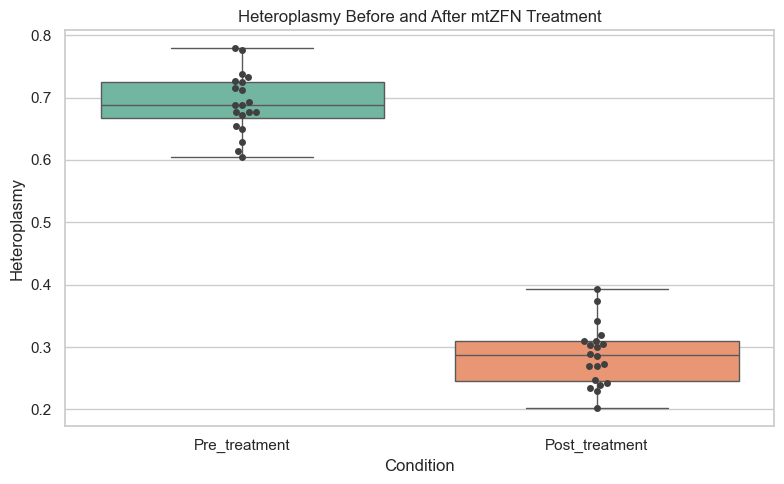

Two-tailed t-test p-value: {p_val:.4e}


In [4]:
np.random.seed(42)
n = 20
pre = np.random.normal(0.70, 0.05, n)
post = np.random.normal(0.30, 0.05, n)
df = pd.DataFrame({
    'Animal_ID': [f'Mouse_{{i+1}}' for i in range(n)],
    'Pre_treatment': pre,
    'Post_treatment': post
})
df_melted = df.melt(id_vars='Animal_ID', var_name='Condition', value_name='Heteroplasmy')
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x='Condition', y='Heteroplasmy', palette='Set2')
sns.swarmplot(data=df_melted, x='Condition', y='Heteroplasmy', color='.25')
plt.title('Heteroplasmy Before and After mtZFN Treatment')
plt.tight_layout()
plt.show()
t_stat, p_val = ttest_ind(pre, post)
print(f'Two-tailed t-test p-value: {{p_val:.4e}}')

## Simulate mtDNA Copy Number Changes

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_6837/820337402.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=copy_melt, x='Condition', y='CopyNumber', palette='Set3')


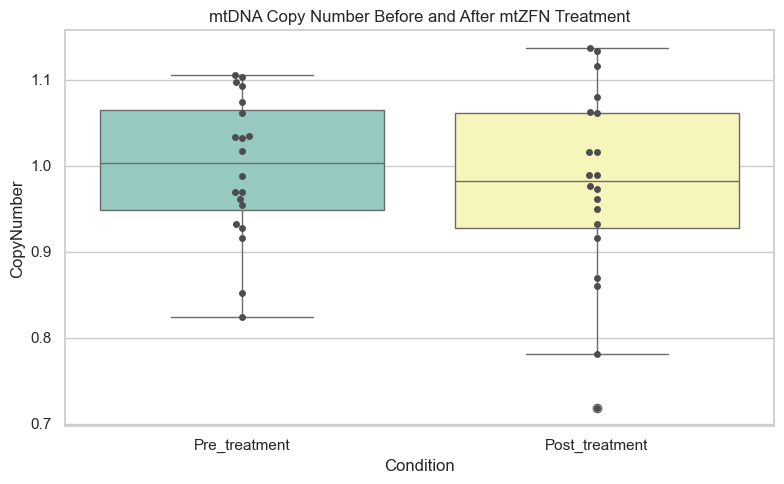

mtDNA copy number p-value: {p_val_copy:.4e}


In [7]:
pre_copy = np.random.normal(1.0, 0.1, n)
post_copy = np.random.normal(0.98, 0.1, n)
copy_df = pd.DataFrame({
    'Animal_ID': [f'Mouse_{{i+1}}' for i in range(n)],
    'Pre_treatment': pre_copy,
    'Post_treatment': post_copy
})
copy_melt = copy_df.melt(id_vars='Animal_ID', var_name='Condition', value_name='CopyNumber')
plt.figure(figsize=(8, 5))
sns.boxplot(data=copy_melt, x='Condition', y='CopyNumber', palette='Set3')
sns.swarmplot(data=copy_melt, x='Condition', y='CopyNumber', color='.3')
plt.title('mtDNA Copy Number Before and After mtZFN Treatment')
plt.tight_layout()
plt.show()
_, p_val_copy = ttest_ind(pre_copy, post_copy)
print(f'mtDNA copy number p-value: {{p_val_copy:.4e}}')

In [1]:
# --- Environment Setup ---
!pip install numpy pandas seaborn matplotlib scipy scikit-learn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
print("Environment ready.")

Environment ready.


In [3]:
def simulate_mitochondria(t_end=60, dt=0.5, pump_rate=1.0, k_atp=0.02, k_u=0.015, ucp1=0.4, mode="MIXED"):
    t = np.arange(0, t_end + dt, dt)
    pmf = np.zeros_like(t)
    atp_rate = np.zeros_like(t)
    heat_rate = np.zeros_like(t)
    pmf[0] = 0.5
    
    for i in range(1, len(t)):
        atp_flux = k_atp * pmf[i-1]
        ucp_flux = k_u * pmf[i-1] * ucp1
        
        if mode == "ATP": ucp_flux *= 0.2
        elif mode == "HEAT": atp_flux *= 0.2
        
        dpmf = pump_rate - atp_flux - ucp_flux - 0.001 * pmf[i-1]
        pmf[i] = max(0, pmf[i-1] + dt*dpmf)
        atp_rate[i], heat_rate[i] = atp_flux, ucp_flux

    return pd.DataFrame({"time_s": t, "pmf": pmf, "atp_rate": atp_rate, "heat_rate": heat_rate})

# Generate dataset
df_sim = simulate_mitochondria()
df_sim.to_csv("synthetic_mitochondria_dataset.csv", index=False)
df_sim.head()

,time_s,pmf,atp_rate,heat_rate
0,0.0,0.500000,0.000000,0.000000
1,0.5,0.993250,0.010000,0.003000
2,1.0,1.479841,0.019865,0.005959
3,1.5,1.959863,0.029597,0.008879
4,2.0,2.433405,0.039197,0.011759


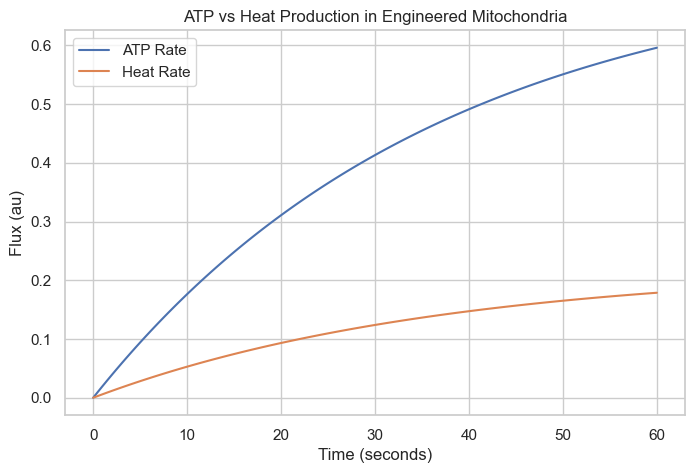

In [5]:
sns.lineplot(data=df_sim, x="time_s", y="atp_rate", label="ATP Rate")
sns.lineplot(data=df_sim, x="time_s", y="heat_rate", label="Heat Rate")
plt.title("ATP vs Heat Production in Engineered Mitochondria")
plt.xlabel("Time (seconds)")
plt.ylabel("Flux (au)")
plt.legend()
plt.savefig("fig_atp_heat_dynamics.png", dpi=300)
plt.show()

In [7]:
# Load experimental calorimetry if available, else fallback to simulation
try:
    df_exp = pd.read_csv("experimental_calorimetry.csv")
except FileNotFoundError:
    print("Experimental file missing, using synthetic dataset")
    df_exp = df_sim.copy()

def model_func(t, k_atp, k_u):
    return k_atp * np.exp(-k_u * t)

popt, pcov = curve_fit(model_func, df_exp["time_s"], df_exp["atp_rate"])
print(f"Estimated k_atp = {popt[0]:.4f}, k_u = {popt[1]:.4f}")

Experimental file missing, using synthetic dataset
Estimated k_atp = 0.1781, k_u = -0.0226


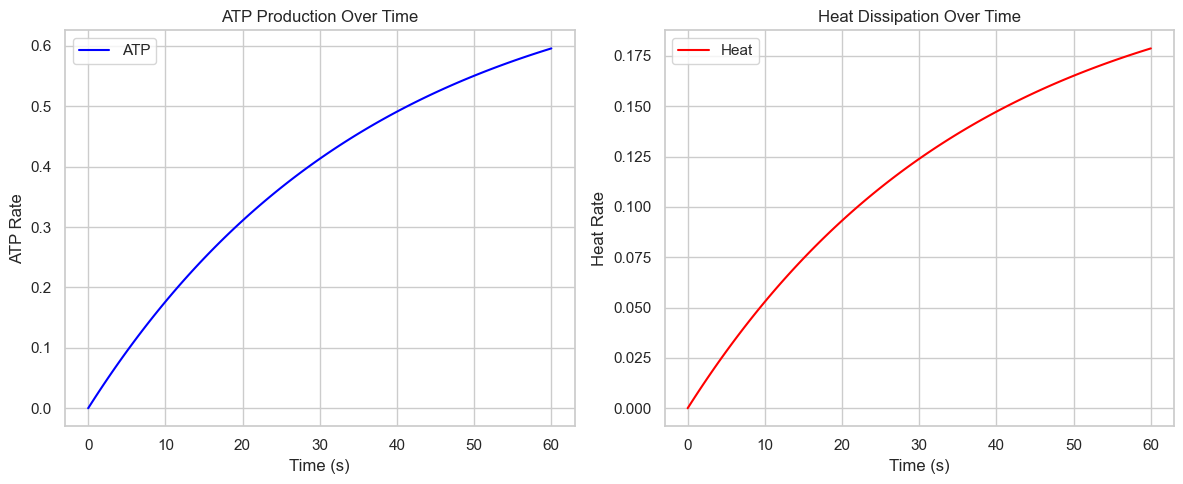

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ATP vs time
sns.lineplot(ax=ax[0], data=df_sim, x="time_s", y="atp_rate", color="blue", label="ATP")
ax[0].set_title("ATP Production Over Time")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("ATP Rate")

# Heat vs time
sns.lineplot(ax=ax[1], data=df_sim, x="time_s", y="heat_rate", color="red", label="Heat")
ax[1].set_title("Heat Dissipation Over Time")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Heat Rate")

plt.tight_layout()
plt.savefig("fig_summary_atp_heat.png", dpi=300)
plt.show()

In [11]:
df_sim.to_csv("synthetic_mitochondria_dataset.csv", index=False)
print("Dataset saved as synthetic_mitochondria_dataset.csv")

Dataset saved as synthetic_mitochondria_dataset.csv
